In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib notebook
plt.style.use('seaborn-colorblind')
sns.set_style('white')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

## Load data

In [2]:
online_data = pd.read_csv('/exlibris/urm/tomerk/playground/sfly/online.csv', sep=',', encoding='utf-8', quoting=csv.QUOTE_NONE)
order_data = pd.read_csv('/exlibris/urm/tomerk/playground/sfly/order.csv', sep=',', encoding='utf-8', quoting=csv.QUOTE_NONE)

### Exploring order data

In [3]:
print(order_data.describe())
print('prodcat2 has {} null values (small amount)'.format(order_data['prodcat2'].isna().sum()))
print('Target Catergories:',order_data.prodcat1.unique())
order_data.head(2)

              custno          ordno       prodcat2       prodcat1        revenue
count  263278.000000  263278.000000  261455.000000  263278.000000  263278.000000
mean    19244.733855   64173.395620      37.384330       2.920924      74.939302
std     19414.103037   43064.595961      44.639098       1.696565      43.277175
min         1.000000       1.000000       2.000000       1.000000       0.000000
25%      3438.000000   26505.000000       5.000000       2.000000      37.430000
50%     11389.500000   59040.500000      16.000000       2.000000      74.930000
75%     31459.000000   98340.750000      58.000000       4.000000     112.280000
max     71427.000000  154405.000000     263.000000       7.000000     150.000000
prodcat2 has 1823 null values (small amount)
Target Catergories: [1 7 3 2 4 5]


,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.3
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.1


### Exploring online data

In [4]:
print(online_data.describe())
print('Target Catergories:',online_data.category.unique())
print('Event1 has {0:.2f} null values'.format(online_data['event1'].isna().sum()/online_data['session'].count()))
print('There are {} unique sessions out of {} rows'.format(online_data.session.nunique(),online_data['session'].count()))
online_data.head(2)

            session        visitor         custno       category         event1         event2
count  9.547740e+05  954774.000000  954774.000000  954774.000000  164928.000000  954774.000000
mean   1.893075e+06  246963.121538   37011.541473       2.684933       4.501576       5.666678
std    1.086779e+06  145929.540403   21559.691539       0.571617       3.494639       2.368242
min    2.000000e+00       1.000000       6.000000       1.000000       1.000000       1.000000
25%    9.554362e+05  125528.250000   17985.000000       2.000000       1.000000       4.000000
50%    1.903075e+06  252901.000000   38040.000000       3.000000       4.000000       7.000000
75%    2.845886e+06  377563.000000   56516.000000       3.000000       7.000000       7.000000
max    3.750761e+06  505850.000000   71427.000000       3.000000      11.000000      10.000000
Target Catergories: [1 2 3]
Event1 has 0.83 null values
There are 850235 unique sessions out of 954774 rows


,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1


## Creating the dataset according to design

In [5]:
# Limiting the date time to "YYYY HH:" inorder to match between the tables. Since the actual order time wasn't at the 
# exact time as the online activity
online_data['date_merge'] = online_data.dt.apply(lambda x: x[:14])
order_data['date_merge'] = order_data.orderdate.apply(lambda x: x[:14])

# Merging the tables with a left join to keep all the customers activity
df = online_data.merge(order_data,right_on=['custno', 'prodcat1','date_merge'],\
                        left_on=['custno', 'category','date_merge'],\
                        how='left')

# Since we are only after to learn which category the customer is more likely to purchase. I'm keeping only the activities
# that led to an order
df = df[df['revenue'].notnull()]
df.fillna(0,inplace=True)

# Group by 'session','custno','category','ordno','prodcat2'
df = df.groupby(['session','custno','category','ordno','prodcat2']).agg({
        'event1': lambda x: x.sum(),
        'event2': lambda x: x.sum(),
        'date_merge': lambda x: x.max(),
        'revenue': lambda x: x.max(),
        'orderdate': lambda x: x.max()}).reset_index()

In [6]:
df.head()

,session,custno,category,ordno,prodcat2,event1,event2,date_merge,revenue,orderdate
0,283,22625,2,35614.0,3.0,0.0,4,2016-07-14 18:,20.82,2016-07-14 18:57:28
1,283,22625,2,35614.0,4.0,0.0,4,2016-07-14 18:,23.74,2016-07-14 18:57:28
2,932,61978,2,123507.0,5.0,1.0,7,2016-07-09 03:,51.28,2016-07-09 03:04:39
3,1109,20982,2,32674.0,3.0,2.0,7,2016-06-08 18:,31.11,2016-06-08 18:44:10
4,1353,7818,2,13912.0,3.0,0.0,3,2016-03-27 17:,93.27,2016-03-27 17:30:12


## Feature engineering

Features ideas

Revenue: 
Build features based on customer historical activity (prior to the current session): 
    1. Avg Revenue per item - Implemented
    2. Max Revenue per item
    3. Min Revenue per item

Time: 
    1. Bin according to time of day (Morning, Noon, evening, Night). Can be timezone normalized. 
    2. Bin according to holidays in the year

Orders: 
Build features based on customer historical orders (prior to the current session): 
    1. Number of orders - Implemented
    2. Average number of items per order
    3. Average revenue per order
    4. Days since last purchase

Events:
    1. Sum of the total events (considering NaN as 0) - Implemented
    2. Binary feature: If both events were used in a session (>0): 1-Yes ; 0- No

prodcat2: Product details - Won't be used as it won't be available during the prediction time.


In [7]:
# Create feature: customer historical revenue - Avg Revenue per item
df['historical_avg_revenue']=df.apply(lambda x: df[(df.custno==x['custno']) & (df.date_merge < x['date_merge'])].revenue.values.mean() if len(df[(df.custno==x['custno']) & (df.date_merge < x['date_merge'])])> 0 else 0,axis=1).fillna(0)

In [8]:
# Create feature: customer historical order - Number of orders
df['historical_cnt_orders']=df.apply(lambda x: df[(df.custno==x['custno']) & (df.date_merge < x['date_merge'])].ordno.nunique(),axis=1)

In [9]:
# Create feature: Sum of the total events
df['Total_events'] = df.event1 + df.event2

In [10]:
df.columns

Index(['session', 'custno', 'category', 'ordno', 'prodcat2', 'event1', 'event2', 'date_merge', 'revenue', 'orderdate', 'historical_avg_revenue', 'historical_cnt_orders', 'Total_events'], dtype='object')

## Feature selection

In [11]:
# Remove columns which are no longer needed 
df.drop(['session','custno','ordno','date_merge','orderdate','prodcat2'],inplace=True,axis=1)

In [12]:
df.columns

Index(['category', 'event1', 'event2', 'revenue', 'historical_avg_revenue', 'historical_cnt_orders', 'Total_events'], dtype='object')

In [13]:
# Perfroming an Anova test for each feature to see if they diffrentiate between the classes
for feature in df.columns[1:]:
    print(feature,'\t'*2,stats.f_oneway(df[df.category==1][feature].values,df[df.category==2][feature].values,df[df.category==3][feature].values))

event1 		 F_onewayResult(statistic=38.55397074609412, pvalue=2.3340729064959642e-17)
event2 		 F_onewayResult(statistic=9.249128299134853, pvalue=9.7642315632565e-05)
revenue 		 F_onewayResult(statistic=0.530173715612396, pvalue=0.588531655306214)
historical_avg_revenue 		 F_onewayResult(statistic=35.17675055757564, pvalue=6.548637878760568e-16)
historical_cnt_orders 		 F_onewayResult(statistic=38.365185721054566, pvalue=2.8119943016069365e-17)
Total_events 		 F_onewayResult(statistic=4.742058086087937, pvalue=0.008755005014894785)


In [14]:
# We can see that the revenue feature pvalue is higher than 0.05, so I'll remove it
df.drop('revenue',inplace=True,axis=1)

----------------------------------------
 We can see some outliers in every feature, but I believe that they are not significate so we won't remove them
For a project with many more features we can use clustering tools like: Local outlier factor and DBSCAN


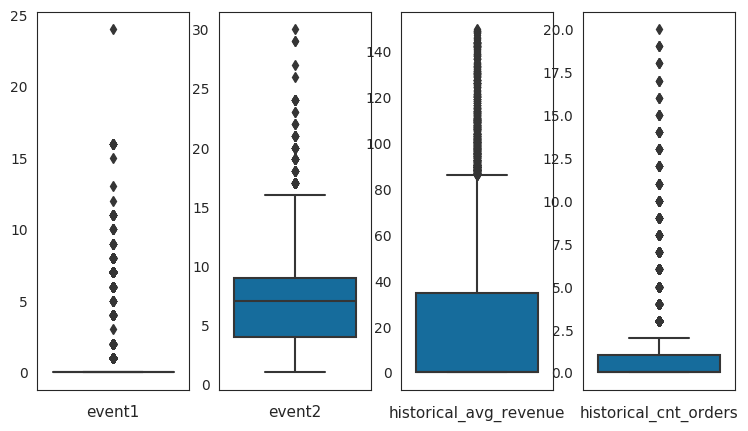

In [15]:
# looking at the main feature distribution to notice if we have major ourliers.
plt.figure(figsize=(9,5), dpi=100)
plt.subplot(141)
ax = sns.boxplot(df[['event1']],orient='v')
ax.set_xlabel('event1', fontsize=11)
plt.subplot(142)
ax = sns.boxplot(df[['event2']],orient='v')
ax.set_xlabel('event2', fontsize=11)
plt.subplot(143)
ax = sns.boxplot(df[['historical_avg_revenue']],orient='v')
ax.set_xlabel('historical_avg_revenue', fontsize=11)
plt.subplot(144)
ax = sns.boxplot(df[['historical_cnt_orders']],orient='v')
ax.set_xlabel('historical_cnt_orders', fontsize=11)
print('----------------------------------------\n We can see some outliers in every feature, but I believe that they are not significate so we won\'t remove them')
print('For a project with many more features we can use clustering tools like: Local outlier factor and DBSCAN')

Visulazing 2 of the features distribution per category. 
This allows to see their distribution per category and have a feel if this feature has a good chance to diffrentiate 
between the classes
----------------------------------------
We can see that both features have a similar distribution between the classes. But we'll keep them to see how they'll 
perform in the model


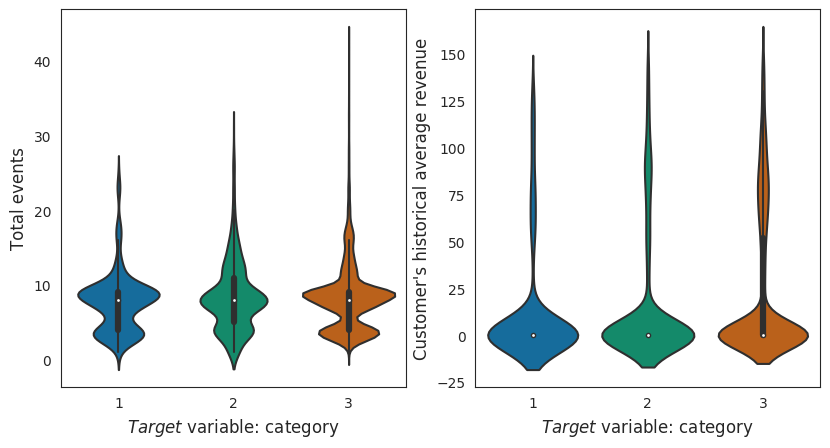

In [16]:
print('Visulazing 2 of the features distribution per category. \nThis allows to see their distribution per category and have a feel if this feature has a good chance to diffrentiate \nbetween the classes')
plt.figure(figsize=(9.8,5), dpi=100)
plt.subplot(121)
ax = sns.violinplot('category', 'Total_events', data=df);
# ax.set_title('Historical Risk vs. Current risk', fontsize=14)
ax.set_ylabel('Total events', fontsize=12)
ax.set_xlabel('$\it{Target}$ variable: category', fontsize=12)

plt.subplot(122)
ax = sns.violinplot('category', 'historical_avg_revenue', data=df);
ax.set_ylabel('Customer\'s historical average revenue', fontsize=12)
ax.set_xlabel('$\it{Target}$ variable: category', fontsize=12)
print('----------------------------------------\nWe can see that both features have a similar distribution between the classes. But we\'ll keep them to see how they\'ll \nperform in the model')

## Model design and sampling

In [17]:
# Let's see the classes distribution in the complete dataset
print(df.category.value_counts())
print('We can see that category 1 is not well represented and we have an unbalanced dataset')

3    4072
2    1209
1     440
Name: category, dtype: int64
We can see that category 1 is not well represented and we have an unbalanced dataset


In [18]:
# Sampling the dataset into two groups: Training and Test.
# Using stratify sampling to make sure we have the same distribution in the test set (since we have unbalanced dataset)
# I've decided to split the data 80% for training and 20% for test.
# Added random_state for reproducing the runs
include_features = ['event1', 'event2', 'historical_avg_revenue', 'historical_cnt_orders', 'Total_events']
X_train, X_test, y_train, y_test = train_test_split(df[include_features],
                                                    df.category,
                                                    test_size=0.2,
                                                    stratify=df.category,
                                                    random_state=42)
print('Comment: If we had more data, I would prefer to split the dataset into three groups: Training, Validation, Test. The reason for three groups is that we do the model tunning according to validation set feedback and then testing the model decision rule on a clean/unseen dataset (test set)')

Comment: If we had more data, I would prefer to split the dataset into three groups: Training, Validation, Test. The reason for three groups is that we do the model tunning according to validation set feedback and then testing the model decision rule on a clean/unseen dataset (test set)


In [19]:
# Since category 1 is not well represented I decided to give it more weigth
class_weight = {1:10,
               2:1,
               3:1}

# Designing Logistic regression model (Parametric model)
# setting C with small number for more regularization (l2)
logreg = LogisticRegression(C=1,random_state=42,n_jobs=-1)

# Designing a RF model
# setting max_depth=6, min_samples_leaf=10, and min_samples_split = 10 to avoid overfitting
# setting max_features = 3 to create diverse trees
model = RandomForestClassifier(n_estimators=500, 
                               criterion = 'entropy',
                               max_depth=6, 
                               min_samples_leaf=10,
                               min_samples_split = 10,
                               bootstrap = False,                               
                               max_features = 3,
                               random_state=0,
                               class_weight=class_weight,
                               n_jobs=-1)

## Model generation

In [20]:
print(model.fit(X_train, y_train))
print(logreg.fit(X_train, y_train))

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={1: 10, 2: 1, 3: 1}, criterion='entropy',
                       max_depth=6, max_features=3, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


## Model evaluation

In [21]:
y_pred = logreg.predict(X_test[include_features])
print('LR model\n',classification_report(y_test, y_pred, target_names=['1', '2','3']))
print('We can see that the LR model doesn\'t work well with this data as it always predict category 3\n')

y_pred = model.predict(X_test[include_features])
cm = confusion_matrix(y_test, y_pred)
print('RF model\n',classification_report(y_test, y_pred, target_names=['1', '2','3']))
print('We can see that the RF model is better than the LR model, but have a total accuracy of 34%')
print('Based on the buisness need we can decide on the needed KPI and tune the model accordingly')

LR model
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        88
           2       0.00      0.00      0.00       242
           3       0.71      1.00      0.83       815

    accuracy                           0.71      1145
   macro avg       0.24      0.33      0.28      1145
weighted avg       0.51      0.71      0.59      1145

We can see that the LR model doesn't work well with this data as it always predict category 3



/exlibris/urm/esploro/lib64/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF model
               precision    recall  f1-score   support

           1       0.10      0.78      0.17        88
           2       1.00      0.01      0.02       242
           3       0.74      0.38      0.50       815

    accuracy                           0.34      1145
   macro avg       0.61      0.39      0.23      1145
weighted avg       0.74      0.34      0.38      1145

We can see that the RF model is better than the LR model, but have a total accuracy of 34%
Based on the buisness need we can decide on the needed KPI and tune the model accordingly


Here we can the samples from the test set. We can see that the model makes alot of mistakes by predicting class 1 when its actually class 3 and 2 (This is mainly because of the class weights that I configured)


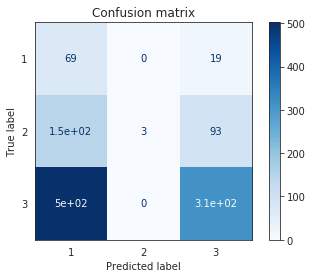

In [22]:
# We can visualize the confusion matrix for the RF model
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['1','2','3'],
                                 cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix')
print('Here we can the samples from the test set. We can see that the model makes alot of mistakes by predicting class 1 when its actually class 3 and 2 (This is mainly because of the class weights that I configured)')

In [23]:
# Looking at Feature importance
important_features_dict = {}
for x,i in enumerate(model.feature_importances_):
    important_features_dict[x]=i


important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print('Most important features - RF')
print('----------------------------')
for k in important_features_list:
    print(X_train.columns[k],'\t'*4,important_features_dict.get(k))

print('\nWe can see that event2 has the most influence among the features and event1 has the least influence')

Most important features - RF
----------------------------
event2 				 0.3114180880587827
historical_avg_revenue 				 0.24193412336963716
Total_events 				 0.21059660666181798
historical_cnt_orders 				 0.19297931617414238
event1 				 0.04307186573561976

We can see that event2 has the most influence among the features and event1 has the least influence


## Summary

I have designed a model based on the business question: if a customer buys a product, which product will it be. The dataset created represent sessions that resulted in an order. Each row represents the entire session activity with the product category that was purchased. The date set includes 5721 rows:
category 1:     440
category 2:    1209
category 3:    4072

I have trained two classification models (parametric - LR and A-parametric - RF). The LR didn't perform well as it predicted the same category for all samples. The RF model acted better, with 34% accuracy. With higher precision for categories 2 and 3. And a higher recall for category 1. The model macro-average for precision is 0.61 and for recall is 0.33 (simple average over the 3 categories). The most predictive feature was found to be event2.

The business need is crucial for deciding on a single metric (KPI) to estimate the model performance. When understanding the business need, we can set appropriate KPIs and hopefully create a single metric that represents the model performance and will assist in models comparison.